# **DenseNet121**

In [1]:
import os
import shutil
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-29 19:17:55.663700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 19:17:55.663848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 19:17:55.831294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_list = [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

for classes in dir_list:
    src_path = '/kaggle/input/sugarcane-leaf-akash/Sugarcane Leaf Image Dataset/All Classes/' + classes
    dst_path = '/kaggle/working/temp/' + classes + '/' + classes
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

In [3]:


import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_list = [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

for classes in dir_list:
    
    kaggle_input_dir = '/kaggle/working/temp/' + classes

    temp_dir = '/kaggle/working/augment/' + classes

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    generated_images = datagen.flow_from_directory(
        kaggle_input_dir,
        save_to_dir=temp_dir,
        batch_size = 1,
        save_prefix=classes,
        save_format='jpg'
    )

    num_images = max(800, min(800, len(generated_images)))
    for i in range(num_images):
        generated_image = next(generated_images)



Found 471 images belonging to 1 classes.
Found 1722 images belonging to 1 classes.
Found 314 images belonging to 1 classes.
Found 343 images belonging to 1 classes.
Found 346 images belonging to 1 classes.
Found 430 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 652 images belonging to 1 classes.
Found 663 images belonging to 1 classes.
Found 1194 images belonging to 1 classes.
Found 316 images belonging to 1 classes.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import os

# Define dataset paths
dataset_path = '/kaggle/working/augment'
categories = os.listdir(dataset_path)
num_classes = len(categories)

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data()

# Ensure that we have loaded images
if len(images) == 0:
    raise Exception("No images loaded. Check dataset path and image files.")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

print("Data loading and preprocessing completed successfully.")


Data loading and preprocessing completed successfully.


## Loading, Preprocessing, and Augmenting Image Dataset

This Python code performs the following tasks:

1. **Imports necessary libraries and modules** for image processing, data manipulation, and machine learning.

2. **Defines dataset paths** and counts the number of classes based on the number of directories in the dataset path.

3. **Loads images and labels** from the dataset path, resizes images to 224x224, and assigns labels based on the directory name.

4. **Splits the data** into training and validation sets.

5. **Normalizes the pixel values** of the images and converts labels to one-hot encoding.

6. **Applies data augmentation** to the training set using `ImageDataGenerator`.

The code ensures that the images are loaded successfully, and prints a message when data loading and preprocessing are completed.

In [5]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

import math
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [6]:
def create_densenet121_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

densenet121_model = create_densenet121_model(input_shape=(224, 224, 3), num_classes=num_classes)


def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
callbacks = [
    ModelCheckpoint('densenet121_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1),
    lr_scheduler,
    reduce_lr
]

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Creating and Configuring a DenseNet121 Model for Image Classification

This Python code performs the following tasks:

1. **Defines a function `create_densenet121_model`** to create a DenseNet121 model with pre-trained weights from ImageNet, additional dense and dropout layers, and a final classification layer. The model is compiled with the Adam optimizer and categorical cross-entropy loss.

2. **Creates an instance of the DenseNet121 model** with a specific input shape and number of classes.

3. **Defines a function `step_decay`** for learning rate decay, which decreases the learning rate by a factor of 0.5 every 10 epochs.

4. **Creates a learning rate scheduler** using the `step_decay` function and a `ReduceLROnPlateau` callback to further reduce the learning rate when the validation accuracy stops improving.

5. **Defines callbacks for training**, including `ModelCheckpoint` to save the model with the best validation accuracy, `EarlyStopping` to stop training when the validation accuracy stops improving for 5 epochs, and the learning rate scheduler and reducer.

In [7]:
# Train the model
history_densenet121 = densenet121_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)
densenet121_model.save('densenes121.h5')
# Evaluate the model
scores = densenet121_model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {scores[0]}, Validation Accuracy: {scores[1]}')

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/220 ━━━━━━━━━━━━━━━━━━━━ 2:54:52 48s/step - accuracy: 0.0938 - loss: 3.1981

I0000 00:00:1717010890.298638     235 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717010890.376271     235 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.4727 - loss: 1.5945

W0000 00:00:1717010971.406231     234 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 134s 392ms/step - accuracy: 0.4733 - loss: 1.5925 - val_accuracy: 0.8068 - val_loss: 0.5950 - learning_rate: 0.0010
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 336ms/step - accuracy: 0.7773 - loss: 0.6120 - val_accuracy: 0.8523 - val_loss: 0.3830 - learning_rate: 0.0010
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 335ms/step - accuracy: 0.8197 - loss: 0.4943 - val_accuracy: 0.8722 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 338ms/step - accuracy: 0.8307 - loss: 0.4273 - val_accuracy: 0.8869 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 334ms/step - accuracy: 0.8495 - loss: 0.3805 - val_accuracy: 0.8693 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 75s 330ms/step - accuracy: 0.8617 - loss: 0.3480 - val_accuracy: 0.8852 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 76s 335ms/step - accuracy: 0.8700 - loss

In [8]:
loss, accuracy = densenet121_model.evaluate(X_val, y_val)
accuracy

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9288 - loss: 0.1496


0.9238636493682861

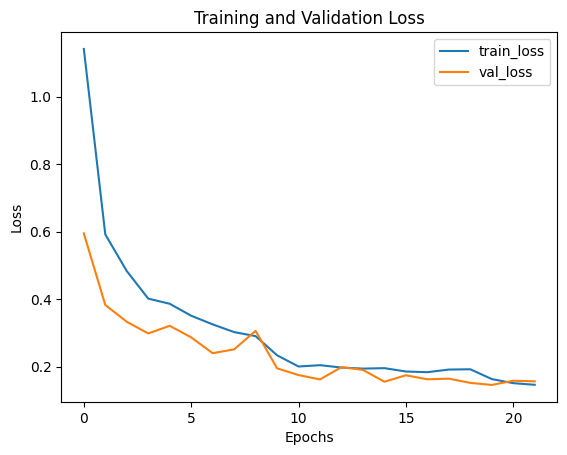

In [9]:
plt.plot(history_densenet121.history['loss'], label='train_loss')
plt.plot(history_densenet121.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

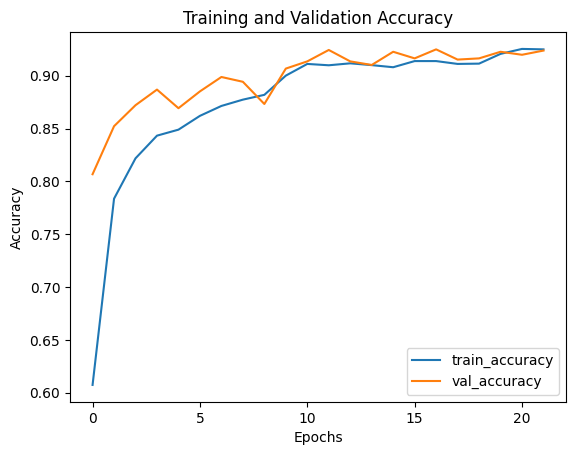

In [10]:
plt.plot(history_densenet121.history['accuracy'], label='train_accuracy')
plt.plot(history_densenet121.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 3/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

W0000 00:00:1717012593.733247     234 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step


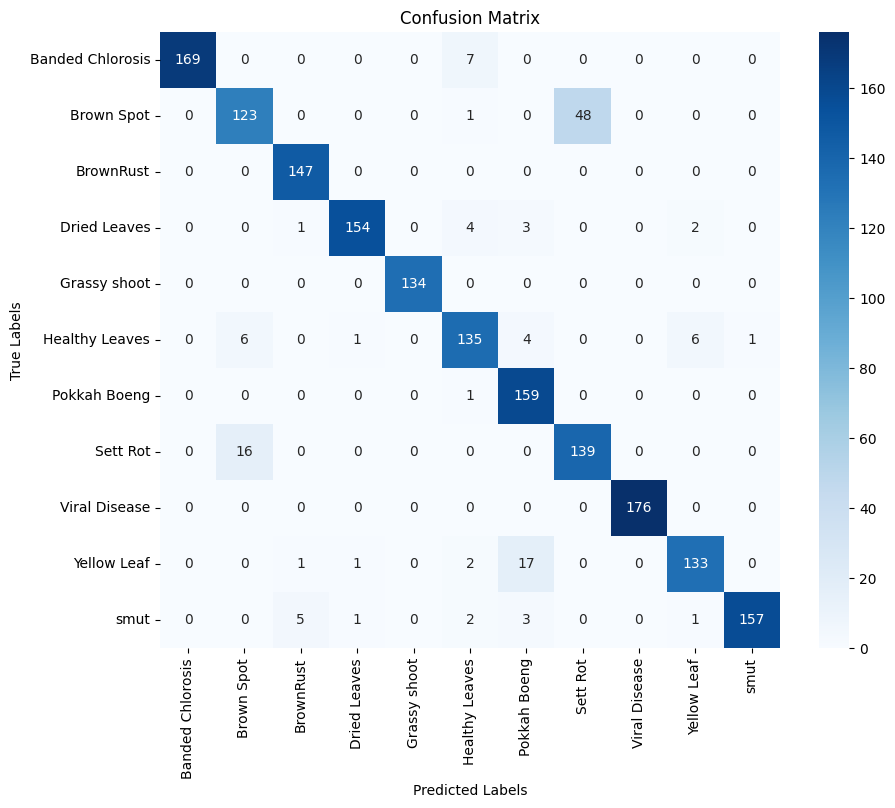

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Define class names for better visualization
class_names = dir_list  # The same list used for your classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report_dict = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Display the DataFrame
print(class_report_df)



55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
                  precision    recall  f1-score      support
Banded Chlorosis   1.000000  0.960227  0.979710   176.000000
Brown Spot         0.848276  0.715116  0.776025   172.000000
BrownRust          0.954545  1.000000  0.976744   147.000000
Dried Leaves       0.980892  0.939024  0.959502   164.000000
Grassy shoot       1.000000  1.000000  1.000000   134.000000
Healthy Leaves     0.888158  0.882353  0.885246   153.000000
Pokkah Boeng       0.854839  0.993750  0.919075   160.000000
Sett Rot           0.743316  0.896774  0.812865   155.000000
Viral Disease      1.000000  1.000000  1.000000   176.000000
Yellow Leaf        0.936620  0.863636  0.898649   154.000000
smut               0.993671  0.928994  0.960245   169.000000
accuracy           0.923864  0.923864  0.923864     0.923864
macro avg          0.927301  0.925443  0.924369  1760.000000
weighted avg       0.927917  0.923864  0.923868  1760.000000


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step


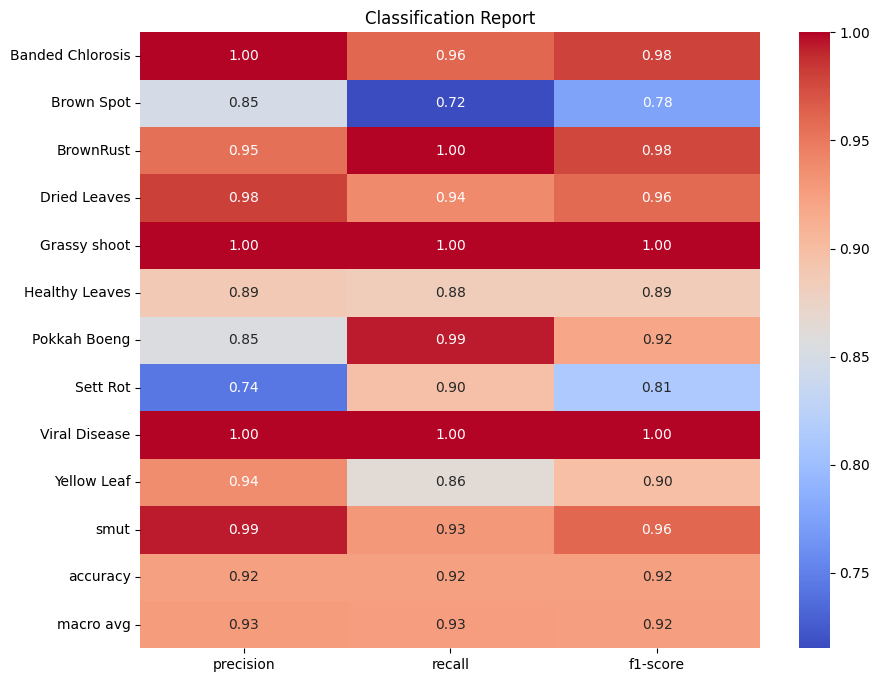

In [13]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


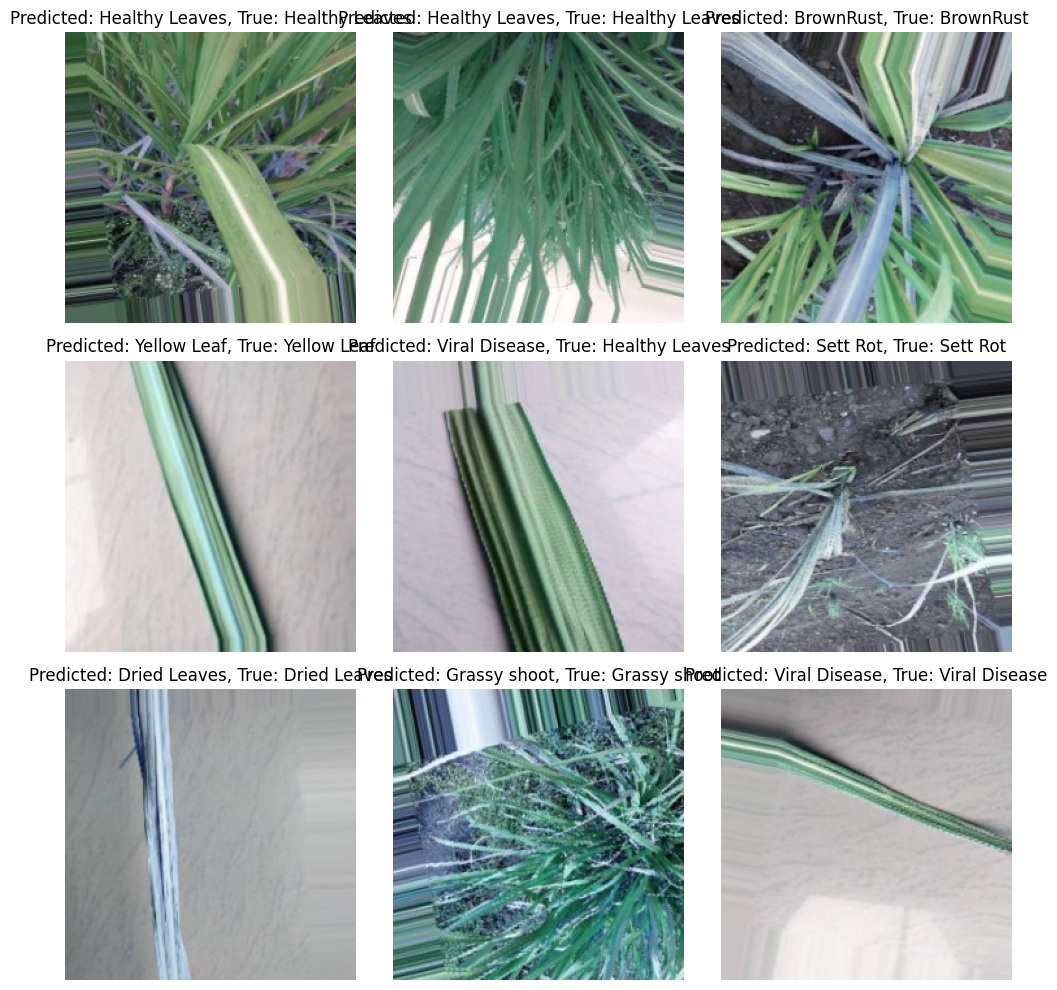

In [14]:
import matplotlib.pyplot as plt
import numpy as np



y_val_pred_prob = densenet121_model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)


class_names = categories  


def plot_predictions(X, y_true, y_pred, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(f"Predicted: {class_names[y_pred[i]]}, True: {class_names[y_true[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 9 pic: 
plot_predictions(X_val, y_val_true, y_val_pred, class_names, num_images=9)
